# Circuit Construction 

The `Circuit` class forms the unit of computation that we send off to a quantum co-processor. Let's make the circuit.

In [1]:
from pytket import Circuit

trivial_circuit = Circuit()  # no qubits or bits
quantum_circ = Circuit(4)    # 4 qubits, no bits
mixed_circ = Circuit(2, 2)   # 2 qubits, 2 bits

named_circ = Circuit(2,2,"my_circuit")  # named circuit

## Basic Gates

Basic quantum gates represent some unitary operation applied to some qubits. Adding them to a `Circuit` just requires specifying which qubits you  want to apply them to. For controlled-gates, the convention is to give the control qubits first, followed by the target qubits.

In [2]:
from pytket import Circuit

circ = Circuit(4)  # qubits are numbered 0-3
circ.X(0)          # apply an X gate to qubit 0
circ.CX(1,3)       # and apply a CX gate with control qubit 1 and target qubit 3
circ.Z(3)          # apply a Z gate to qubit 3

circ.get_commands()  # get the list of gates in the circuit

[X q[0];, CX q[1], q[3];, Z q[3];]

For parameterised gates, such as rotations, the parameters is always given first. Because of the prevalence of rotations with anhles given by fractions of $\pi$ in practical quantum computing, the unit for all angular parameters is the half-turn. $1$ half turn is equal to $\pi$ radians)

In [3]:
from pytket import Circuit

circ = Circuit(2)

circ.Rx(0.5, 0)  # apply an Rx gate with angle 0.5, which is pi/2 to qubit 0
circ.CRz(0.3,1,0) # controlled Rz of angle 0.3pi, control qubit 1, target qubit 0

[Rx(0.5) q[0]; CRz(0.3) q[1], q[0]; ]

A large selection of common gates are available in this way. However, for less commonly used gates, a wider variety is available using the `OpType` enum, which can be added using the `Circuit.add_gate` method.

In [4]:
from pytket import Circuit, OpType

circ = Circuit(5)

circ.add_gate(OpType.CnX, [0,1,4,3])  # apply Controlled X gate with control qubit 0,1,4 and target qubit 3
circ.add_gate(OpType.XXPhase,0.7,[0,2])  # add e^{-i 0.7 pi / 2) XX} on qubits 0 and 2
circ.add_gate(OpType.PhasedX, [-0.1,0.5], [3])  # adds Rz(-0.5 pi) ; Rx(-0.1 pi) ; Rz(0.5 pi) on qubit 3

[CnX q[0], q[1], q[4], q[3]; XXPhase(0.7) q[0], q[2]; PhasedX(3.9, 0.5) q[3]; ]

In the above example, we asked for a `PhasedX` with angles `[-0.1, 0.5]`, but received `PhasedX(3.9, 0.5)`. `pytket` will freely map angles into the range $[0,r)$
for some range parameter
that depends on the `OpType`, preserving the unitary matrix (including global phase).

## Measurements

Measurements go a step further by interacting with both quantum and classical data. The convention used in `pytket` is that all measurements are non-destructive, single-qubit measurements in the $Z$ basis; other forms of measurements can be constructed by combining these with other operations.

Adding a measurement works just like adding any other gate, where the first argument is the qubit to be measured and the second specifies the classical bit store the result in.

In [5]:
from pytket import Circuit

circ = Circuit(4,2)
circ.Measure(0,0)  # measure qubit 0 into bit 0
circ.CX(1,2)
circ.CX(1,3)
circ.H(1)
circ.Measure(1,1)  # measurement of IXXX measure qubit 1 into bit 1

[Measure q[0] --> c[0]; CX q[1], q[2]; CX q[1], q[3]; H q[1]; Measure q[1] --> c[1]; ]

because the classical bits are treated as statically assigned locations, writing to the same bit multiple times will overwrite the previous value.

In [6]:
from pytket import Circuit

circ = Circuit(2,1)
circ.Measure(0,0) # the firrst measurement
circ.CX(0,1)
circ.Measure(1,0) # overwrites the first result with new measurement

[Measure q[0] --> c[0]; CX q[0], q[1]; Measure q[1] --> c[0]; ]

Depending on where we plan on running our circuits, the backend or simulator might have different requirements on the structure of measurements in the circuits. For example, statevector simulators will only work deterministically for pure-quantum circuits, so will fail if any measures are present at all. More crucially, near-term quantum hardware almost always requires all measurements to occur in a single parallel layer at the end of the circuit (i.e. we cannot measure a qubit in the middle of the circuit).

In [7]:
from pytket import Circuit

circ0 = Circuit(2,2) # all measurement at end
circ0.H(1)
circ0.Measure(0,0)
circ0.Measure(1,1)


circ1 = Circuit(2,2) # all measurement at end
circ1.Measure(0,0)
circ1.H(1)
circ1.Measure(1,1)


circ2 = Circuit(2,2) # all measurement at end
circ2.Measure(0,0)
circ2.CX(0,1)
circ2.Measure(1,1)

circ3 = Circuit(2,1) # all measurement at end
circ3.Measure(0,0)
circ3.Measure(1,0)


[Measure q[0] --> c[0]; Measure q[1] --> c[0]; ]

The simplest way to guarantee this is to finish the circuit by measuring all qubits. There is a short-hand function `Circuit.measure_all()` to make this easier.

In [8]:
from pytket import Circuit

# measure qubit 0 in Z basis and 1 in X basis
circ = Circuit(2, 2)
circ.H(1)
circ.measure_all()

# measure_all() adds bits if they are not already defined, so equivalently
circ = Circuit(2)
circ.H(1)
circ.measure_all()

[Measure q[0] --> c[0]; H q[1]; Measure q[1] --> c[1]; ]

On devices where mid-circuit measurements are available, they may be highly noisy and not apply just a basic projector on the quantum state. We can view these as “effectively destructive” measurements, where the qubit still exists but is in a noisy state. In this case, it is recommended to actively reset a qubit after measurement if it is intended to be reused.

In [9]:
from pytket import Circuit, OpType

circ = Circuit(2, 2)
circ.Measure(0, 0)
# Actively reset state to |0>
circ.add_gate(OpType.Reset, [0])
# Conditionally flip state to |1> to reflect measurement result
circ.X(0, condition_bits=[0], condition_value=1)
# Use the qubit as if the measurement was non-destructive
circ.CX(0, 1)

[Measure q[0] --> c[0]; Reset q[0]; IF ([c[0]] == 1) THEN X q[0]; CX q[0], q[1]; ]

## Barriers
The concept of barriers comes from low-level classical programming. They exist as instructions but perform no active operation. Instead, their function is twofold:

1. At compile time , prevent the compiler from reordering operations around the barrier
2. At runtime. ensure that all operations before the barrier must have finished before any operations after the barrier starts.



In [10]:
from pytket import Circuit, OpType

circ = Circuit(4,2)
circ.H(0)
circ.CX(1,2)
circ.add_barrier([0,1,2,3],[0,1])  # add barrier on all qubits and bits

circ.Measure(0,0)
circ.Measure(2,1)

[H q[0]; CX q[1], q[2]; Barrier q[0], q[1], q[2], q[3], c[0], c[1]; Measure q[0] --> c[0]; Measure q[2] --> c[1]; ]

## Registers and IDs

Using Integer Values to refer to each odf the qubits and bits work fine for small-scale experiments, but when dealing with larger and more complicated circuits, its much easier to manage if we are able to name our resources to attach semantic meaning to them and group them into related collection.

Each unit resource is associated with a `UnitID` which gives a name and some index. A quantum/classical register is hence some collection of `UnitID`s with the same name, dimension of index, and type of associated resource. 

In [11]:
from pytket import Circuit, OpType, Qubit, Bit
circ = Circuit()

qreg = circ.add_q_register("qreg", 3)  # add a qubit register
anc = Qubit("ancilla")  # create a named qubit  

circ.add_qubit(anc)

par = Bit("parity",[0,0])  # add a named bit with 2D index
circ.add_bit(par)

circ.CX(qreg[0],anc)
circ.CX(qreg[1],anc)
circ.Measure(anc,par)

[CX qreg[0], ancilla; CX qreg[1], ancilla; Measure ancilla --> parity[0, 0]; ]

A Circuit can be inspected to identify what qubits and bits it contains.

In [12]:
from pytket import Circuit, Qubit

circ = Circuit()
circ.add_q_register("a", 4)
circ.add_qubit(Qubit("b"))
circ.add_c_register("z", 3)

print(circ.qubits)
print(circ.bits)

[a[0], a[1], a[2], a[3], b]
[z[0], z[1], z[2]]


The circuit will reject new  qubit ot register if it disagrees with existing IDs

In [13]:
from pytket import Circuit, Qubit, Bit

circ = Circuit()
# set up a circuit with qubit a[0]
circ.add_qubit(Qubit("a", 0))

# rejected because "a" is already a qubit register
circ.add_bit(Bit("a", 1))

RuntimeError: Cannot add bit with ID "a[1]" as register is not compatible

The basic integer identifiers are actually a special case, referring to the default qubit (q[i]) and bit (c[i]) registers. We can create the UnitID using the nameless Qubit and Bit constructors.

In [14]:
from pytket import Circuit, Qubit, Bit

circ = Circuit(4, 2)
circ.CX(Qubit(0), Qubit("q", 1))    # same as circ.CX(0, 1)
circ.Measure(Qubit(2), Bit("c", 0)) # same as circ.Measure(2, 0)

[Measure q[2] --> c[0]; CX q[0], q[1]; ]

In some circumstances, it may be useful to rename the resources in the Circuit. Given a partial map on UnitID s, Circuit.rename_units() will change the association of IDs to resources (as long as the final labelling would still have consistent types for all registers). Any unspecified IDs will be preserve

In [15]:
from pytket import Circuit, Qubit, Bit

circ = Circuit(2, 2)
circ.add_qubit(Qubit("a", 0))

qubit_map = {
    Qubit("a", 0) : Qubit(3),
    Qubit(1) : Qubit("a", 0),
    Bit(0) : Bit("z", [0, 1]),
}
circ.rename_units(qubit_map)
print(circ.qubits)
print(circ.bits)

[a[0], q[0], q[3]]
[c[1], z[0, 1]]


## Composing Circuits

Since `Circuit`s are defined to have open inputs and outputs, it is perfectly natural to compose them by unifying the outputs of one with the input of another. Appending one `Circuit` to the end of another matches the inputs and outputs with the same `UnitID`

In [16]:
from pytket import Circuit, Qubit, Bit

circ = Circuit(2, 2)
circ.CX(0, 1)
circ.Rz(0.3,1)
circ.CX(0,1)

measures = Circuit(2,2)
measures.H(1)
measures.measure_all()

circ.append(measures)
circ

[CX q[0], q[1]; Rz(0.3) q[1]; CX q[0], q[1]; Measure q[0] --> c[0]; H q[1]; Measure q[1] --> c[1]; ]

If one Circuit lacks some unit present in the other, then we treat it as if it is an identity on that unit. In the extreme case where the Circuit s are defined with disjoint sets of UnitID s, the Circuit.append() method will compose them in parallel.

In [17]:
from pytket import Circuit

circ = Circuit()
a = circ.add_q_register("a", 2)
circ.Rx(0.2, a[0])
circ.CX(a[0], a[1])

next_circ = Circuit()
b = next_circ.add_q_register("b", 2)
next_circ.Z(b[0])
next_circ.CZ(b[1], b[0])

circ.append(next_circ)
circ

[Rx(0.2) a[0]; Z b[0]; CX a[0], a[1]; CZ b[1], b[0]; ]

To change which units get unified, we could use Circuit.rename_units() as seen before, but in the case where we just want to append a subcircuit like a gate, we can do this with Circuit.add_circuit().

In [18]:
from pytket import Circuit, Qubit

circ = Circuit()
a = circ.add_q_register("a", 2)
circ.Rx(0.2, a[0])
circ.CX(a[0], a[1])

next_circ = Circuit(2)
next_circ.Z(0)
next_circ.CZ(1, 0)

circ.add_circuit(next_circ, [a[1], a[0]])

# This is equivalent to:
# temp = next_circ.copy()
# temp.rename_units({Qubit(0) : a[1], Qubit(1) : a[0]})
# circ.append(temp)

circ

[Rx(0.2) a[0]; CX a[0], a[1]; Z a[1]; CZ a[0], a[1]; ]

## Statevectors and Unitaries

When working with quantum circuits we may want access to the quantum state prepared by our circuit. This can be helpful if we want to check whether our circuit construction is correct. The Circuit.get_statevector() method will produce the statevector of our system after the circuit is applied.

In [19]:
from pytket import Circuit

circ = Circuit(2)
circ.H(0).CZ(0, 1).H(1)
circ.get_unitary()

array([[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j],
       [ 0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j],
       [ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j],
       [ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j]])

## Analysing Circuits

After creating a `Circuit`, we will typically want to inspect what we have constructed to ensure that it agrees with the design we planned. the most basic form is to return the sequence of operations. Iterating through the `Circuit` object will give it back the operations as `Command`s 


because the `Circuit` class identifies circuits up to DAG equivalence, the sequence will be some topological sort of the DAG, but not necessarily identical to the order of the operations were added to the `Circuit`

In [20]:
from pytket import Circuit

circ = Circuit(3)
circ.CX(0,1).CZ(1,2).X(1).Rx(0.3,0)

for _ in circ :  # equivalently, circ.get_commands()
    print(_.op, _.op.type, _.args)

CX OpType.CX [q[0], q[1]]
Rx(0.3) OpType.Rx [q[0]]
CZ OpType.CZ [q[1], q[2]]
X OpType.X [q[1]]


### Drawing a Circuit

In [21]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

circ = Circuit(3)
circ.CX(0, 1).CZ(1, 2).X(1).Rx(0.3, 0)
render_circuit_jupyter(circ) # Render interactive circuit diagram

you can also make it display like a DAG

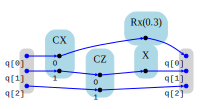

In [22]:
from pytket import Circuit
from pytket.utils import Graph

circ = Circuit(3)
circ.CX(0,1).CZ(1,2).X(1).Rx(0.3,0)
Graph(circ).get_DAG()  # display the DAG

can also be used to desc4ribe the interaction graph of a Circuit consisting only one and two qubit gates

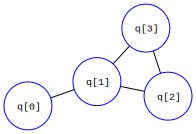

In [23]:
from pytket import Circuit
from pytket.utils import Graph

circ = Circuit(4)
circ.CX(0, 1).CZ(1, 2).ZZPhase(0.63, 2, 3).CX(1, 3).CY(0, 1)
Graph(circ).get_qubit_graph()

The full instruction sequence may often be too much detail for a lot of needs, especially for large circuits. Common circuit metrics like gate count and depth are used to approximate the difficulty of running it on a device, providing some basic tools to help distinguish different implementations of a given algorithm.

In [24]:
from pytket import Circuit

circ = Circuit(3)
circ.CX(0, 1).CZ(1, 2).X(1).Rx(0.3, 0)

print("Total gate count =", circ.n_gates)
print("Circuit depth =", circ.depth())

Total gate count = 4
Circuit depth = 3


 As characterstics of a `Circuit` go, these are pretty basic. In term of approximatiung the noise level, they fail heavily from weighting all gates evenly when, in fact, som e will be much harder to implement than others.


 We can use the `OpType`  enum class to look for the number of gates of a particular type.

In [25]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter

circ = Circuit(3)
circ.T(0)
circ.CX(0,1)
circ.CX(2,0)
circ.add_gate(OpType.CnRy, [0.3], [0,1,2])
circ.T(2)
circ.CZ(0,1)
circ.CZ(1,2)
circ.T(1)

render_circuit_jupyter(circ)  # draw the circuit

print("T gate count =", circ.n_gates_of_type(OpType.T))
print('#1qb gates = ', circ.n_1qb_gates())
print('#2qb gates = ', circ.n_2qb_gates())
print("3qb gates = ", circ.n_nqb_gates(3))  # counst the single CnRy gate (n=3)

print("T gate depth =", circ.depth_by_type(OpType.T))
print("2qb gate depth =", circ.depth_by_type({OpType.CX, OpType.CZ}))

T gate count = 3
#1qb gates =  3
#2qb gates =  4
3qb gates =  1
T gate depth = 3
2qb gate depth = 4


It is also possible to count all the occurences of each `OpType` using the `gate_counts()` function

In [26]:
from pytket.utils.stats import gate_counts

gate_counts(circ)

Counter({<OpType.T: 27>: 3,
         <OpType.CX: 42>: 2,
         <OpType.CZ: 44>: 2,
         <OpType.CnRy: 78>: 1})

## Boxes

Working with individual basic gates is sufficient for implementing arbitrary circuits, but that doesn't mean it is the most convenient option. It is generally far easier to argue the correctness of a circuit's design when it is constructed using higher level constructions

### Circuit Boxes

The simplest example of this is a `CircBox` which wraps up another `Circuit` defined elsewhere into a single black-box. The difference between adding a `CircBox` and just appending the `Circuit` is that the `CircBox` allows us to wrap up and abstract away the internal structure of the subcircuit we are adding so it appears as if it were a single gate when we view the main circuit.

In [27]:
# lets try this
from pytket.circuit import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter   

oracle_circ = Circuit(3, name="Oracle")
for _ in range(3):
    oracle_circ.X(_)

oracle_circ.add_gate(OpType.CnZ, [0,1,2])

for _ in range(3):
    oracle_circ.X(_)

render_circuit_jupyter(oracle_circ)


Now that we have built our circuit, lets wrap it in a `CircBox` , and add it to a another circuit as a subroutine

In [28]:
from pytket.circuit import CircBox

oracle_box = CircBox(oracle_circ)
circ = Circuit(3)
circ.H(0).H(1).H(2)

circ.add_circbox(oracle_box, [0,1,2])

render_circuit_jupyter(circ)